In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/summer21/new/src/

/content/drive/My Drive/summer21/new/src


In [185]:
import pandas as pd

data = pd.read_csv('data/nfoas/nfoas_train.csv', index_col=0)
data

,OA,Ac-Orn,Ala,Arg,Asn,C0,C10,C10:1,C10:2,C12,C12:1,C12-DC,C14,C14:1,C14:1-OH,C14:2,C14:2-OH,C16,C16:1,C16:1-OH,C16:2,C16:2-OH,C16-OH,C18,C18:1,C18:1-OH,C18:2,C2,C3,C3:1,C3-DC (C4-OH),C3-OH,C4,C4:1,C5,C5:1,C5:1-DC,C5-DC (C6-OH),C5-M-DC,C5-OH (C3-DC-M),...,PC ae C38:4,PC ae C38:5,PC ae C38:6,PC ae C40:1,PC ae C40:2,PC ae C40:3,PC ae C40:4,PC ae C40:5,PC ae C40:6,PC ae C42:0,PC ae C42:1,PC ae C42:2,PC ae C42:3,PC ae C42:4,PC ae C42:5,PC ae C44:3,PC ae C44:4,PC ae C44:5,PC ae C44:6,Met,Orn,Phe,Sarcosine,Ser,SM (OH) C14:1,SM (OH) C16:1,SM (OH) C22:1,SM (OH) C24:1,SM C16:0,SM C16:1,SM C18:0,SM C18:1,SM C20:2,SM C24:0,SM (OH) C22:2,Spermidine,total DMA,Trp,Tyr,Val
129,1,-1.194751,0.376300,-1.507504,0.387557,0.830381,-0.229572,0.569114,-0.110944,0.038160,0.236674,0.119246,0.355402,0.169227,0.007164,0.139820,0.015363,0.316178,0.088969,-0.221009,-0.309344,0.127688,-0.484831,0.016943,0.503089,0.122873,0.655874,-0.249391,-0.386109,-0.215774,0.040444,-0.397120,-0.273732,-0.218711,-0.345475,-0.253951,-0.095859,-0.372256,-0.582659,-0.338660,...,0.086032,-0.107979,-0.827225,-0.937845,-1.018888,-0.928217,-0.409502,-0.915588,-0.810031,-1.192879,-0.748026,-1.066227,-1.307212,-0.851423,-0.981123,-0.757164,-0.966319,-1.104495,-0.643946,-0.437694,0.700813,-0.614605,0.047405,-0.073773,-2.287709,-1.309117,-0.753556,-0.447341,-1.111935,-1.709077,-0.854123,-1.363643,-0.430347,-1.195215,-1.309910,-0.548983,0.206165,-0.464247,0.444967,0.175966
120,1,-1.194751,0.377589,-1.401456,-0.068679,-0.358432,-0.187407,0.664489,-0.007204,0.038160,0.149219,0.072505,0.133702,0.197189,-0.279448,-0.468180,-0.206822,1.042689,0.088969,0.214060,-0.148720,-0.200148,-0.733074,0.055835,0.902425,-0.033010,0.705437,-1.159706,-1.036551,-0.210600,-0.198712,-0.322389,-0.373271,-0.244078,-0.442097,-0.239409,-0.314591,-0.103037,0.235967,-0.275808,...,-0.387487,-0.535152,-1.161805,-0.645908,-0.307660,-0.350225,-0.814887,-0.894653,-1.043700,-1.587383,-1.350298,-1.139777,-1.085995,-0.442770,-0.607268,-1.026581,-0.299567,-0.024199,-0.512872,-0.532906,0.681173,-0.377681,0.134522,-0.629407,-1.380597,-0.551855,-1.298387,-0.648704,-0.682414,-0.484493,0.688955,0.328812,-0.213556,-1.318421,-1.032641,0.145362,1.328186,-1.015602,0.377864,0.337190
280,0,0.891861,0.221938,0.410164,0.951410,1.045291,-0.425404,-1.073919,0.120862,-0.015013,-1.273238,-0.350189,0.266971,-1.467269,-0.183816,-0.656806,0.680597,-0.643492,-0.918909,0.105453,0.492190,1.107317,-1.728526,-0.445121,-0.512618,0.044970,-0.414008,0.139160,1.130015,-0.164264,0.050293,-0.099084,0.929056,-0.136960,0.288862,-0.105727,-0.074104,0.354248,0.551371,-0.015137,...,-0.721215,-0.479797,-0.344234,0.289880,-0.867994,-1.230581,-1.085975,-0.458567,-0.347080,1.394979,0.010835,-0.566691,0.168704,-1.377880,-0.981123,-0.757164,-1.064732,-1.587009,-1.144268,3.019433,-0.521998,1.531876,0.062087,0.806189,-1.055207,-1.145766,-1.012920,-1.107371,-1.995837,-1.585232,-1.766444,-1.629979,-1.634897,-1.585018,-1.009809,-0.945131,-0.447036,0.985239,-1.941034,1.726477
311,0,1.292726,0.093262,0.478735,1.078134,0.270099,0.845845,0.224768,-0.420322,0.269370,-0.060821,0.212596,-0.270657,1.354342,0.007164,0.325369,-0.429226,-0.578397,-0.432063,-0.221009,-0.470127,-0.693121,-0.236834,-0.404900,-0.487530,-0.267415,-0.414008,0.093616,-0.578595,-0.210600,-0.433084,-0.099084,0.377886,-0.212386,-0.177618,-0.210454,-0.292620,-0.179769,0.200753,-0.300912,...,0.177415,0.611900,1.041074,0.790266,1.550248,1.652533,0.783410,0.652523,1.056174,-0.410053,1.066366,1.432712,1.445685,0.445391,0.374073,1.560091,0.846533,0.525217,0.871621,-0.145541,-0.371117,0.083511,-0.530571,0.238304,0.294393,0.529727,0.060890,0.371324,0.859067,0.636924,0.219513,0.095229,0.303459,0.562007,0.547674,-0.945131,0.206165,0.188692,0.656435,-0.051696
355,0,-2.476935,0.594557,1.188127,-0.684349,2.209777,-0.150169,-0.005790,-0.259925,0.164825,-0.083124,0.491581,-0.180202,0.867014,0.102514,0.325369,-0.651852,0.475806,-0.110653,-0.330044,-0.470127,-0.200148,0.999462,0.133289,0.121017,0.122873,0.018718,0.03725

In [186]:
import glob
import pickle
import IPython as ipy

runs = []

for name in glob.glob('results/nfoas/mlpc/*.pkl'):
    with open(name, 'rb') as file:
        runs.append(pickle.load(file))

    print(name)
    ipy.display.clear_output(wait=True)

print(len(runs), 'run(s) of the MR-MOGA')

100 run(s) of the MR-MOGA


In [187]:
import numpy as np

rand_run = runs[np.random.choice(np.arange(len(runs)))]

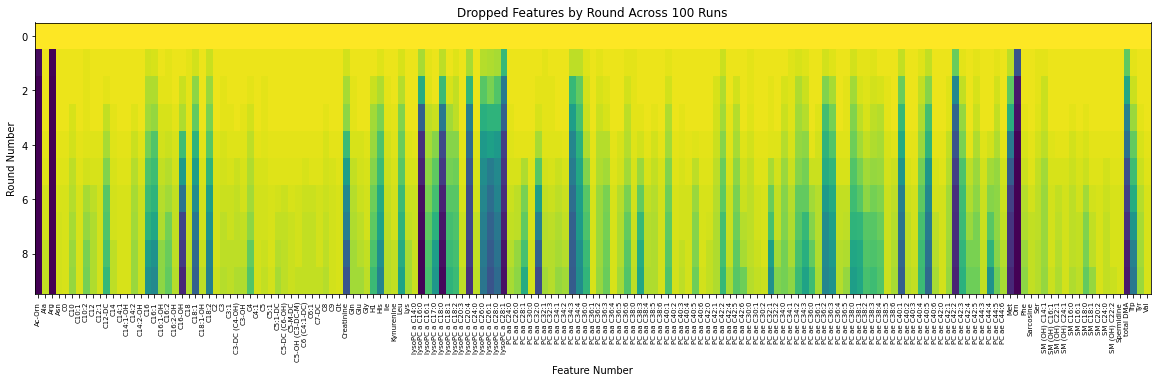

In [188]:
import matplotlib.pyplot as plt
import numpy as np

dropped = np.zeros((10, rand_run.features))

for run in runs:
    for i in range(len(run.indices)):
        dropped[i][run.indices[i]] += 1

fig, ax = plt.subplots(figsize=(20, 5))
im = ax.imshow(dropped, aspect='auto')
plt.xticks(np.arange(rand_run.features), data.columns[1:], rotation='vertical', fontsize=7)
plt.xlabel('Feature Number'), plt.ylabel('Round Number')
plt.title('Dropped Features by Round Across 100 Runs')
plt.show()

In [189]:
ga_paretos = np.hstack([run.paretos[0] for run in runs])
ga_paretos = {tuple(v['data'] + v['index']):v for v in ga_paretos}.values()

print(len(ga_paretos), 'solutions in the pareto fronts of first rounds')

10750 solutions in the pareto fronts of first rounds


In [190]:
mrga_paretos = np.hstack([run.pareto for run in runs])
mrga_paretos = list({tuple(v['data'] + v['index']):v for v in mrga_paretos}.values())

print(len(mrga_paretos), 'solutions in the pareto fronts of all rounds')

35250 solutions in the pareto fronts of all rounds


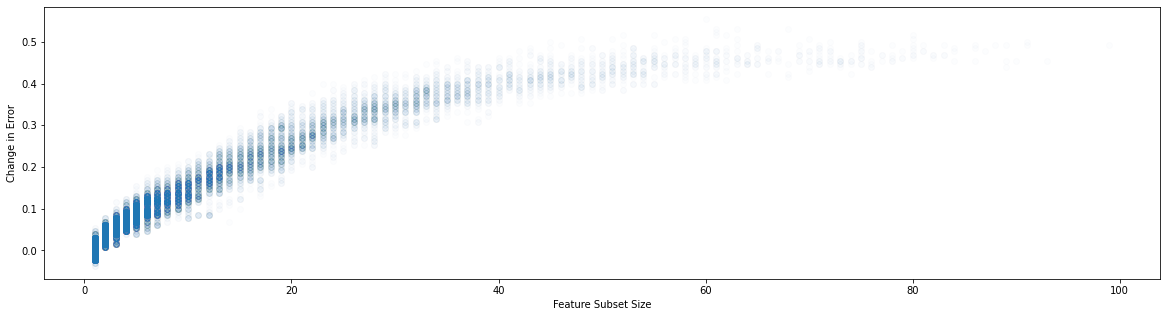

In [191]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter([individual['meta']['size'] for individual in mrga_paretos], [individual['meta']['test'] for individual in mrga_paretos], alpha=0.01)
plt.xlabel('Feature Subset Size'), plt.ylabel('Change in Error')
plt.show()

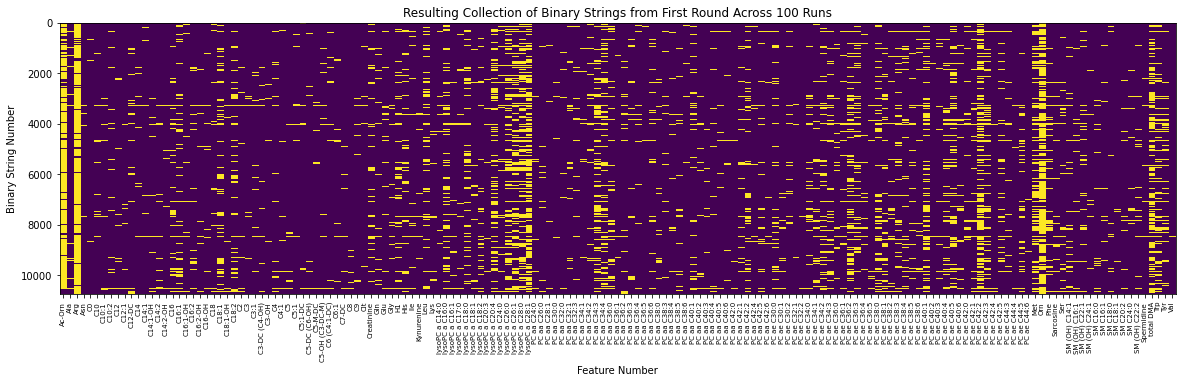

In [192]:
fig, ax = plt.subplots(figsize=(20, 5))
im = ax.imshow([individual['data'] for individual in ga_paretos], aspect='auto', interpolation='none')
ax.set_ylabel('Binary String Number')
ax.set_title('Resulting Collection of Binary Strings from First Round Across 100 Runs')
ax.set_xlabel('Feature Number')

plt.xticks(np.arange(rand_run.features), data.columns[1:], rotation='vertical', fontsize=7)
plt.show()

In [193]:
ga_importance = np.array([run.importances[0] for run in runs]).sum(axis=0)
mrga_importance = np.array([run.importance for run in runs]).sum(axis=0)

In [218]:
from sklearn.neural_network import *
from sklearn.ensemble import *
from sklearn.neighbors import * 
from sklearn.svm import *

model = MLPClassifier(random_state=0)
train = rand_run.train
test = rand_run.test
validate = rand_run.validate
model.fit(train[:,1:], train[:,0])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [162]:
# impurity = model.feature_importances_

In [196]:
from sklearn.inspection import permutation_importance
permutation = permutation_importance(model, test[:,1:], test[:,0]).importances_mean

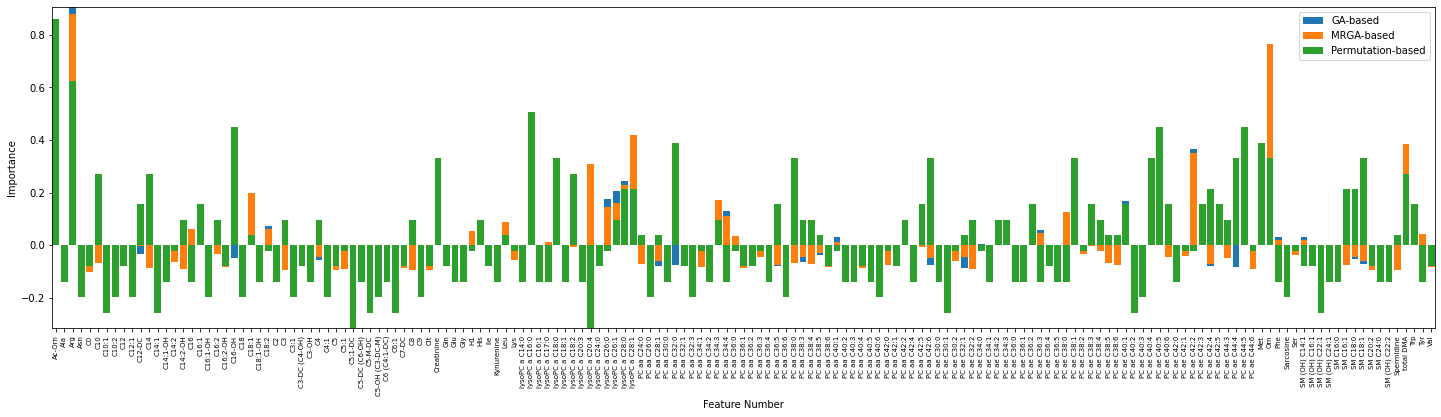

In [197]:
rand_importance_scaled = (rand_run.importance - rand_run.importance.mean()) / rand_run.importance.max()
ga_importance_scaled = (ga_importance - ga_importance.mean()) / ga_importance.max()
mrga_importance_scaled = (mrga_importance - mrga_importance.mean()) / mrga_importance.max()
# impurity_scaled = (impurity - impurity.mean()) / impurity.max()
permutation_scaled = (permutation - permutation.mean()) / permutation.max()

fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(data.columns[1:], ga_importance_scaled, label='GA-based')
ax.bar(np.arange(rand_run.features), mrga_importance_scaled, label='MRGA-based')
ax.bar(data.columns[1:], permutation_scaled, label='Permutation-based')
# ax.bar(data.columns[1:], impurity_scaled, label='Impurity-based')
ax.legend(loc='upper right')
ax.autoscale(tight=True)
ax.set_xticklabels(data.columns[1:])
ax.set_xticks(np.arange(rand_run.features))

fig.tight_layout()

plt.xlabel('Feature Number'), plt.ylabel('Importance')
plt.xticks(np.arange(rand_run.features), data.columns[1:], rotation='vertical', fontsize=7)
plt.show()

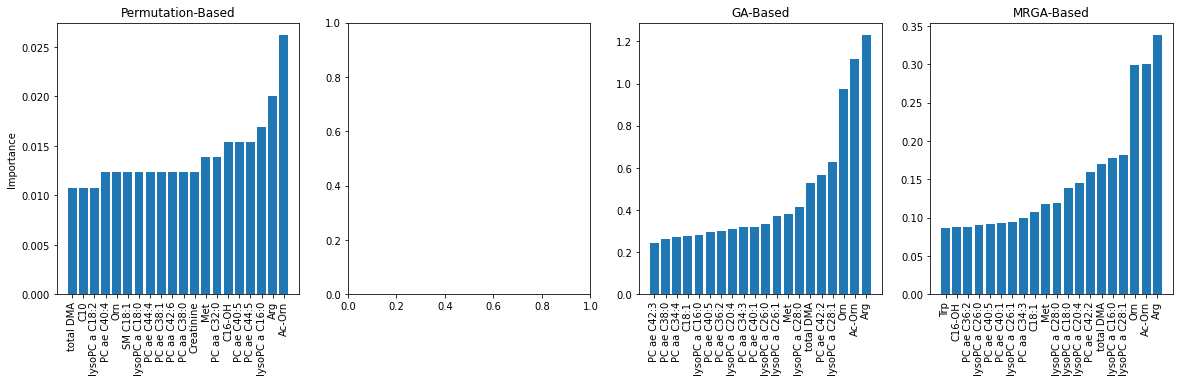

In [220]:
size, bars = 3, 20

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

ax1.bar(data.columns[1:][np.argsort(permutation)][-bars:], permutation[np.argsort(permutation)][-bars:])
ax1.set_xticklabels(data.columns[1:][np.argsort(permutation)][-bars:], rotation='vertical')
ax1.set_title('Permutation-Based')
ax1.set_ylabel('Importance')

# ax2.bar(data.columns[1:][np.argsort(impurity)][-bars:], impurity[np.argsort(impurity)][-bars:])
# ax2.set_xticklabels(data.columns[1:][np.argsort(impurity)][-bars:], rotation='vertical')
# ax2.set_title('Impurity-Based')

ax3.bar(data.columns[1:][np.argsort(ga_importance)][-bars:], ga_importance[np.argsort(ga_importance)][-bars:])
ax3.set_xticklabels(data.columns[1:][np.argsort(ga_importance)][-bars:], rotation='vertical')
ax3.set_title('GA-Based')

ax4.bar(data.columns[1:][np.argsort(mrga_importance)][-bars:], mrga_importance[np.argsort(mrga_importance)][-bars:])
ax4.set_xticklabels(data.columns[1:][np.argsort(mrga_importance)][-bars:], rotation='vertical')
ax4.set_title('MRGA-Based')

plt.show()

In [213]:
ga_synergy = np.array([run.synergies[0] for run in runs]).sum(axis=0)
mrga_synergy = np.array([run.synergy for run in runs]).sum(axis=0)

In [ ]:
# !git clone https://github.com/Yu-Group/iterative-Random-Forest

# %cd /content/drive/My\ Drive/summer21/new/src/iterative-Random-Forest

# !pip install -e .

# from irf import irf_utils 
# from irf.utils import (get_prevalent_interactions, 
#                        visualize_impurity_decrease, 
#                        visualize_prevalent_interactions)
# from irf.ensemble import (wrf, 
#                           wrf_reg)

# %cd /content/drive/My\ Drive/summer21/new/src/

# X_train, y_train = np.ascontiguousarray(train[:,1:]), np.ascontiguousarray(train[:,0])
# X_test, y_test = np.ascontiguousarray(test[:,1:]), np.ascontiguousarray(test[:,0])

# weight = np.ones((X_train.shape[1],))
# weight = weight / np.sum(weight)
# rf = wrf_reg(min_impurity_decrease=0.01)
# rf.fit(X_train, y_train, feature_weight=weight, K = 3, keep_record=False)

# prevalence = get_prevalent_interactions(rf, impurity_decrease_threshold=0, min_support=0, signed=True)

# irf_interaction = np.zeros((rand_run.features, rand_run.features))

# for key in prevalence.keys():
#     for i in range(len(key)):
#         for j in range(len(key)):
#             if i == j:
#                 continue
#             irf_interaction[key[i][0]][key[j][0]] += prevalence[key] / len(key)

# ipy.display.clear_output(wait=True)

In [134]:
# !pip install numpy sklearn-gbmi

# from sklearn_gbmi import *

# h_statistics = h_all_pairs(model, rand_run.test)

# h_interaction = np.zeros((rand_run.features, rand_run.features))
# for i in range(rand_run.features):
#     for j in range(rand_run.features):
#         if i == j:
#             continue
            
#         try:
#             if np.isnan(h_statistics[(i, j)]):
#                 h_interaction[i][j], h_interaction[j][i] = 0, 0
#             else:
#                 h_interaction[i][j], h_interaction[j][i] = h_statistics[(i, j)], h_statistics[(i, j)]
#         except:
#             continue

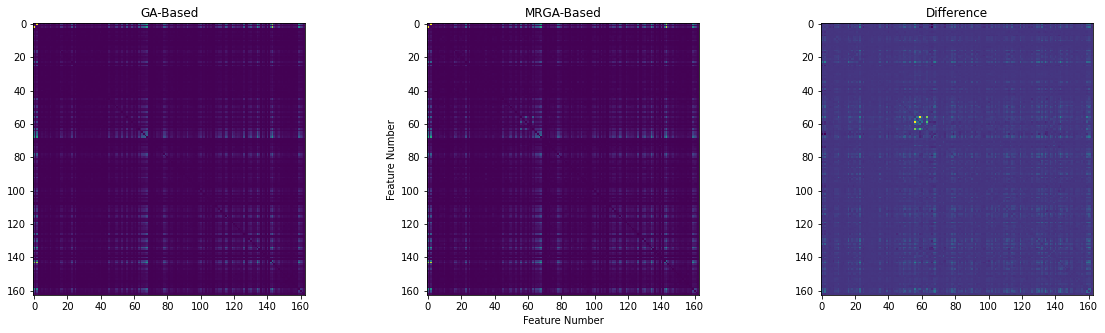

In [214]:
ga_synergy_scaled = (ga_synergy - ga_synergy.mean()) / ga_synergy.max()
mrga_synergy_scaled = (mrga_synergy - mrga_synergy.mean()) / mrga_synergy.max()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.imshow(ga_synergy, interpolation='none')
ax1.set_title('GA-Based')

ax2.imshow(mrga_synergy, interpolation='none')
ax2.set_title('MRGA-Based')
ax2.set_xlabel('Feature Number'), ax2.set_ylabel('Feature Number')

ax3.imshow(mrga_synergy_scaled - ga_synergy_scaled, interpolation='none')

ax3.set_title('Difference')
plt.show()

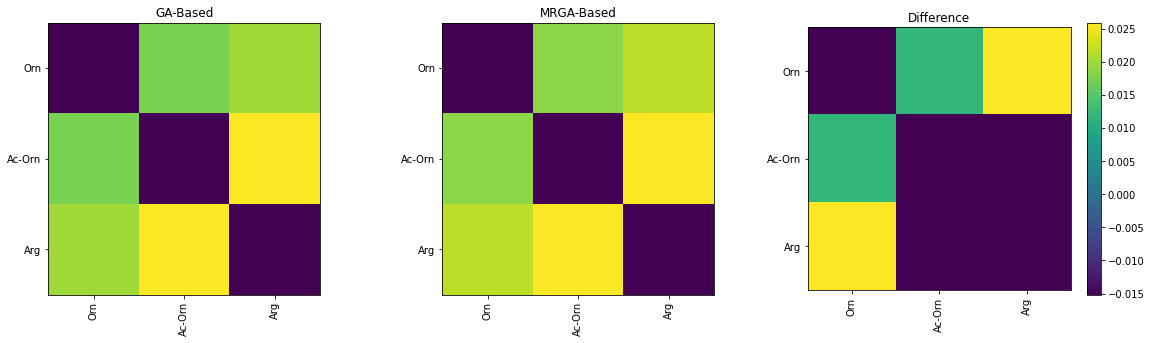

In [230]:
ga_top_synergy = ga_synergy[np.argsort(ga_importance)[-size:]][:,np.argsort(ga_importance)[-size:]]
ga_top_synergy_scaled = (ga_top_synergy - ga_top_synergy.mean()) / ga_top_synergy.max()
mrga_top_synergy = mrga_synergy[np.argsort(mrga_importance)[-size:]][:,np.argsort(mrga_importance)[-size:]]
mrga_top_synergy_scaled = (mrga_top_synergy - mrga_top_synergy.mean()) / mrga_top_synergy.max()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.imshow(ga_top_synergy, interpolation='none')
ax1.set_title('GA-Based')
ax1.set_xticklabels(data.columns[1:][np.argsort(ga_importance)[-size:]], rotation='vertical')
ax1.set_xticks(np.arange(size)), ax1.set_yticks(np.arange(size))
ax1.set_yticklabels(data.columns[1:][np.argsort(ga_importance)[-size:]], rotation='horizontal')

ax2.imshow(mrga_top_synergy, interpolation='none')
ax2.set_title('MRGA-Based')
ax2.set_xticks(np.arange(size)), ax2.set_yticks(np.arange(size))
ax2.set_xticklabels(data.columns[1:][np.argsort(mrga_importance)[-size:]], rotation='vertical')
ax2.set_yticklabels(data.columns[1:][np.argsort(ga_importance)[-size:]], rotation='horizontal')

pos = ax3.imshow(mrga_top_synergy_scaled - ga_top_synergy_scaled, interpolation='none')
ax3.set_title('Difference')
ax3.set_xticks(np.arange(size)), ax3.set_yticks(np.arange(size))
ax3.set_xticklabels(data.columns[1:][np.argsort(mrga_importance)[-size:]], rotation='vertical')
ax3.set_yticklabels(data.columns[1:][np.argsort(ga_importance)[-size:]], rotation='horizontal')

fig.colorbar(pos, ax=ax3)

plt.show()

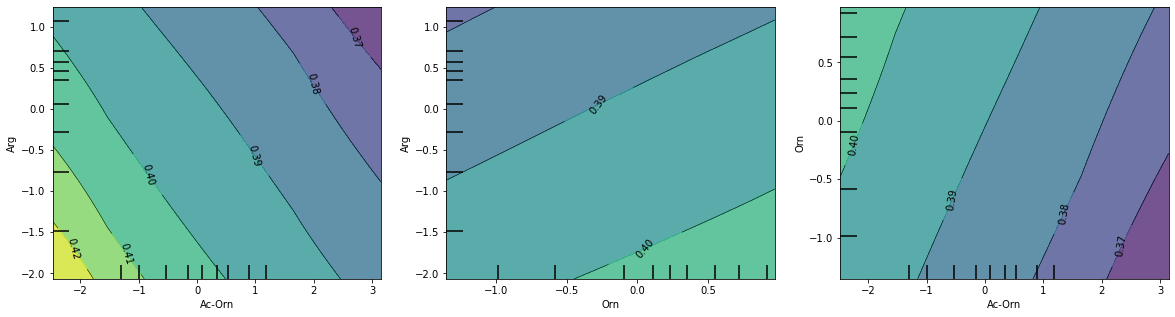

In [219]:
from sklearn.inspection import plot_partial_dependence

plot_partial_dependence(model, data[data.columns[1:]], [('Ac-Orn', 'Arg'), ('Orn', 'Arg'), ('Ac-Orn', 'Orn')])
fig = plt.gcf()
fig.set_size_inches((20, 5))

In [ ]:
# irf_interaction_scaled = (irf_interaction - irf_interaction.mean()) / irf_interaction.max()
# mrga_synergy_scaled = (mrga_synergy - mrga_synergy.mean()) / mrga_synergy.max()

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# ax1.imshow(irf_interaction, interpolation='none')
# ax1.set_title('iRF-Based')

# ax2.imshow(mrga_synergy, interpolation='none')
# ax2.set_title('MRGA-Based')

# ax3.imshow(mrga_synergy_scaled - irf_interaction_scaled, interpolation='none')
# fig.colorbar(pos, ax=ax3)

# ax3.set_title('Difference')
# plt.show()

In [ ]:
# h_top_interaction = h_interaction[np.argsort(mrga_importance)[-size:]][:,np.argsort(mrga_importance)[-size:]]
# h_top_interaction_scaled = (h_top_interaction - h_top_interaction.mean()) / h_top_interaction.max()
# irf_top_interaction = irf_interaction[np.argsort(mrga_importance)[-size:]][:,np.argsort(mrga_importance)[-size:]]
# irf_top_interaction_scaled = (irf_top_interaction - irf_top_interaction.mean()) / irf_top_interaction.max()
# mrga_top_synergy = mrga_synergy[np.argsort(mrga_importance)[-size:]][:,np.argsort(mrga_importance)[-size:]]
# mrga_top_synergy_scaled = (mrga_top_synergy - mrga_top_synergy.mean()) / mrga_top_synergy.max()

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# ax1.imshow(irf_top_interaction, interpolation='none')
# ax1.set_title('iRF-Based')
# ax1.set_xticklabels(data.columns[1:][np.argsort(mrga_importance)[-size:]], rotation='vertical')
# ax1.set_xticks(np.arange(size)), ax1.set_yticks(np.arange(size))
# ax1.set_yticklabels(data.columns[1:][np.argsort(mrga_importance)[-size:]], rotation='horizontal')

# ax2.imshow(mrga_top_synergy, interpolation='none')
# ax2.set_title('MRGA-Based')
# ax2.set_xticks(np.arange(size)), ax2.set_yticks(np.arange(size))
# ax2.set_xticklabels(data.columns[1:][np.argsort(mrga_importance)[-size:]], rotation='vertical')
# ax2.set_yticklabels(data.columns[1:][np.argsort(mrga_importance)[-size:]], rotation='horizontal')

# pos = ax3.imshow(mrga_top_synergy_scaled - h_top_interaction_scaled, interpolation='none')
# ax3.set_title('Difference')
# ax3.set_xticks(np.arange(size)), ax3.set_yticks(np.arange(size))
# ax3.set_xticklabels(data.columns[1:][np.argsort(mrga_importance)[-size:]], rotation='vertical')
# ax3.set_yticklabels(data.columns[1:][np.argsort(mrga_importance)[-size:]], rotation='horizontal')

# fig.colorbar(pos, ax=ax3)

# plt.show()

In [205]:
ga_dependency = np.array([run.dependencies[0] for run in runs]).sum(axis=0)
mrga_dependency = np.array([run.dependency for run in runs]).sum(axis=0)

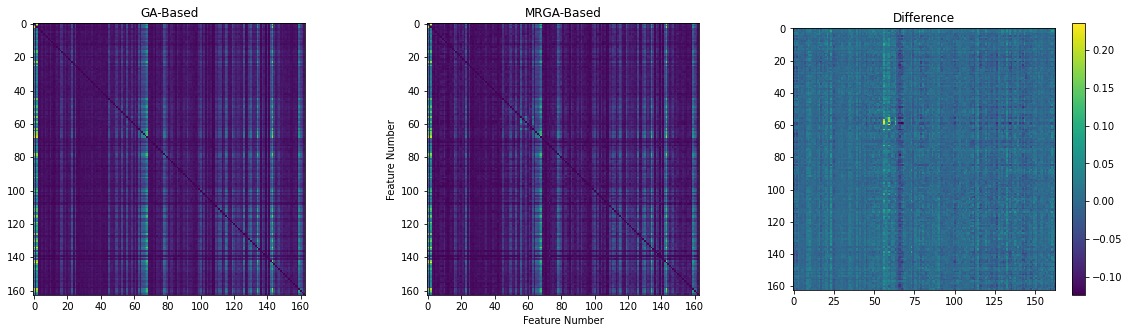

In [206]:
ga_dependency_scaled = (ga_dependency - ga_dependency.mean()) / ga_dependency.max()
mrga_dependency_scaled = (mrga_dependency - mrga_dependency.mean()) / mrga_dependency.max()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.imshow(ga_dependency, interpolation='none')
ax1.set_title('GA-Based')

ax2.imshow(mrga_dependency, interpolation='none')
ax2.set_title('MRGA-Based')
ax2.set_xlabel('Feature Number'), ax2.set_ylabel('Feature Number')

pos = ax3.imshow(mrga_dependency_scaled - ga_dependency_scaled, interpolation='none')
ax3.set_title('Difference')

fig.colorbar(pos, ax=ax3)
plt.show()

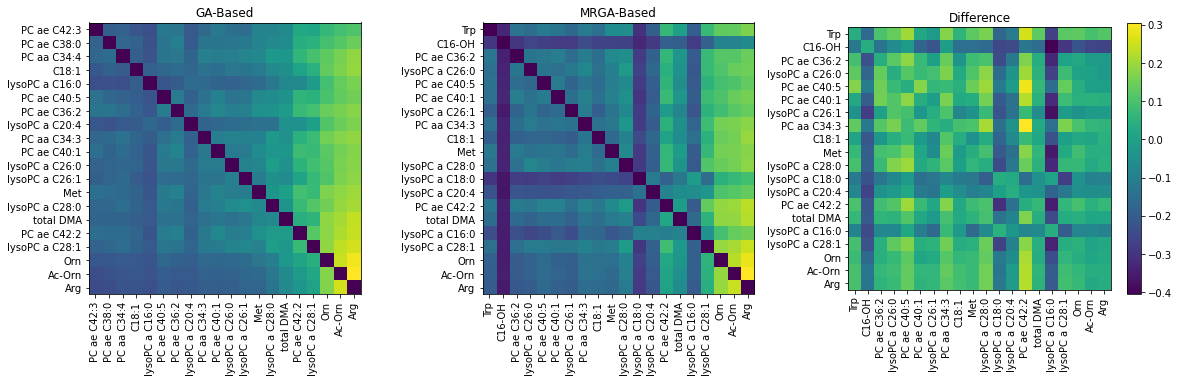

In [207]:
ga_top_dependency = ga_dependency[np.argsort(ga_importance)[-size:]][:,np.argsort(ga_importance)[-size:]]
ga_top_dependency_scaled = (ga_top_dependency - ga_top_dependency.mean()) / ga_top_dependency.max()
mrga_top_dependency = mrga_dependency[np.argsort(mrga_importance)[-size:]][:,np.argsort(mrga_importance)[-size:]]
mrga_top_dependency_scaled = (mrga_top_dependency - mrga_top_dependency.mean()) / mrga_top_dependency.max()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.imshow(ga_top_dependency, interpolation='none')
ax1.set_title('GA-Based')
ax1.set_xticklabels(data.columns[1:][np.argsort(ga_importance)[-size:]], rotation='vertical')
ax1.set_xticks(np.arange(size)), ax1.set_yticks(np.arange(size))
ax1.set_yticklabels(data.columns[1:][np.argsort(ga_importance)[-size:]], rotation='horizontal')

ax2.imshow(mrga_top_dependency, interpolation='none')
ax2.set_title('MRGA-Based')
ax2.set_xticks(np.arange(size)), ax2.set_yticks(np.arange(size))
ax2.set_xticklabels(data.columns[1:][np.argsort(mrga_importance)[-size:]], rotation='vertical')
ax2.set_yticklabels(data.columns[1:][np.argsort(mrga_importance)[-size:]], rotation='horizontal')

pos = ax3.imshow(mrga_top_dependency_scaled - ga_top_dependency_scaled, interpolation='none')
ax3.set_title('Difference')
ax3.set_xticks(np.arange(size)), ax3.set_yticks(np.arange(size))
ax3.set_xticklabels(data.columns[1:][np.argsort(mrga_importance)[-size:]], rotation='vertical')
ax3.set_yticklabels(data.columns[1:][np.argsort(mrga_importance)[-size:]], rotation='horizontal')

fig.colorbar(pos, ax=ax3)
plt.show()

In [221]:
from sklearn.metrics import *

model.fit(train[:,1:], train[:,0])

baseline = pd.DataFrame(data=classification_report(model.predict(validate[:,1:]), validate[:,0], output_dict=True)).transpose()
# baseline = mean_squared_error(model.predict(validate[:,1:]), validate[:,0])

baseline

,precision,recall,f1-score,support
0.0,0.961538,0.937500,0.949367,80.000000
1.0,0.901961,0.938776,0.920000,49.000000
accuracy,0.937984,0.937984,0.937984,0.937984
macro avg,0.931750,0.938138,0.934684,129.000000
weighted avg,0.938908,0.937984,0.938212,129.000000


In [222]:
model.fit(train[:,1:][:,np.argsort(ga_importance)[-size:]], train[:,0])

ga_based = pd.DataFrame(data=classification_report(model.predict(validate[:,1:][:,np.argsort(ga_importance)[-size:]]), validate[:,0], output_dict=True)).transpose()
# ga_based = mean_squared_error(model.predict(validate[:,1:][:,np.argsort(ga_importance)[-size:]]), validate[:,0])

ga_based

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,precision,recall,f1-score,support
0.0,0.987179,0.950617,0.968553,81.00000
1.0,0.921569,0.979167,0.949495,48.00000
accuracy,0.961240,0.961240,0.961240,0.96124
macro avg,0.954374,0.964892,0.959024,129.00000
weighted avg,0.962766,0.961240,0.961462,129.00000


In [223]:
model.fit(train[:,1:][:,np.argsort(mrga_importance)[-size:]], train[:,0])

mrga_based = pd.DataFrame(data=classification_report(model.predict(validate[:,1:][:,np.argsort(ga_importance)[-size:]]), validate[:,0], output_dict=True)).transpose()
# mrga_based = mean_squared_error(model.predict(validate[:,1:][:,np.argsort(mrga_importance)[-size:]]), validate[:,0])

mrga_based

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,precision,recall,f1-score,support
0.0,0.987179,0.950617,0.968553,81.00000
1.0,0.921569,0.979167,0.949495,48.00000
accuracy,0.961240,0.961240,0.961240,0.96124
macro avg,0.954374,0.964892,0.959024,129.00000
weighted avg,0.962766,0.961240,0.961462,129.00000


In [225]:
ga_baseline = ga_based - baseline
# ga_baseline = baseline - ga_based
ga_baseline

,precision,recall,f1-score,support
0.0,0.025641,0.013117,0.019186,1.000000
1.0,0.019608,0.040391,0.029495,-1.000000
accuracy,0.023256,0.023256,0.023256,0.023256
macro avg,0.022624,0.026754,0.024341,0.000000
weighted avg,0.023858,0.023256,0.023250,0.000000


In [226]:
mrga_baseline = mrga_based - baseline
# mrga_baseline = baseline - mrga_based

mrga_baseline

,precision,recall,f1-score,support
0.0,0.025641,0.013117,0.019186,1.000000
1.0,0.019608,0.040391,0.029495,-1.000000
accuracy,0.023256,0.023256,0.023256,0.023256
macro avg,0.022624,0.026754,0.024341,0.000000
weighted avg,0.023858,0.023256,0.023250,0.000000


In [227]:
mrga_ga = mrga_based - ga_based
mrga_ga

,precision,recall,f1-score,support
0.0,0.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0,0.0
accuracy,0.0,0.0,0.0,0.0
macro avg,0.0,0.0,0.0,0.0
weighted avg,0.0,0.0,0.0,0.0


In [228]:
import networkx as nx
import json

vertices = rand_run.features
labels = np.array(data.columns[1:])[np.argsort(mrga_importance)[-vertices:]]
graph = nx.DiGraph()

for label in labels:
    graph.add_node(label, weight=mrga_importance[list(data.columns).index(label) - 1])

for i in range(vertices):
    for j in range(vertices):
        if i == j:
            break
        graph.add_edge(labels[i], labels[j], weight=mrga_synergy[data.columns.get_loc(labels[i]) - 1][data.columns.get_loc(labels[j]) - 1])

with open('results/nfoas/mlpc/undirected_graph.json', 'w+') as f:
    json.dump(nx.readwrite.json_graph.cytoscape_data(graph), f)

In [229]:
import networkx as nx
import json

vertices = rand_run.features
labels = np.array(data.columns[1:])[np.argsort(mrga_importance)[-vertices:]]
graph = nx.DiGraph()

for label in labels:
    graph.add_node(label, weight=mrga_importance[list(data.columns).index(label) - 1])

for i in range(vertices):
    for j in range(vertices):
        if i == j:
            continue
        graph.add_edge(labels[i], labels[j], weight=mrga_dependency[data.columns.get_loc(labels[i]) - 1][data.columns.get_loc(labels[j]) - 1])

with open('results/nfoas/mlpc/directed_graph.json', 'w+') as f:
    json.dump(nx.readwrite.json_graph.cytoscape_data(graph), f)